In [25]:
import os
import tarfile
from six.moves import urllib

In [26]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [27]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [28]:
import pandas as pd

In [29]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [30]:
fetch_housing_data()

In [31]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [32]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [33]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [34]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


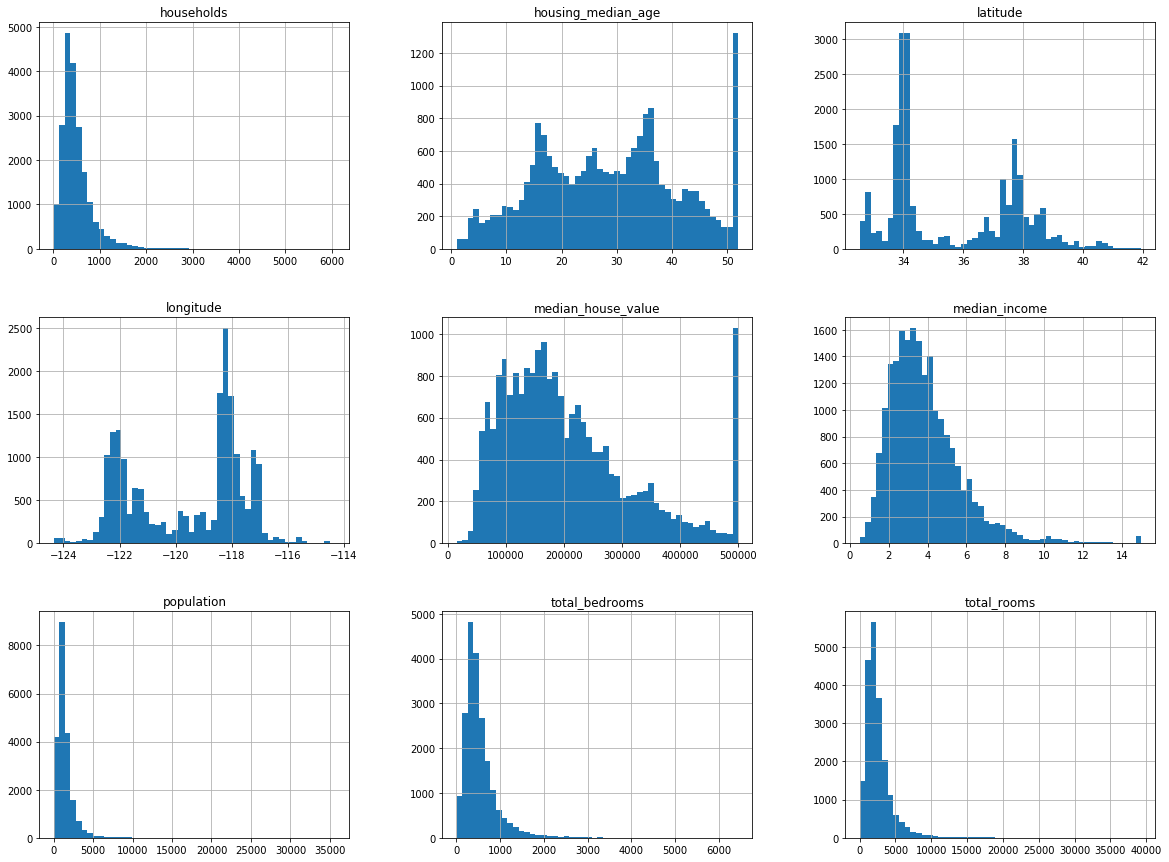

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [37]:
import numpy as np

In [38]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [39]:
from zlib import crc32

In [40]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [41]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [42]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [43]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [46]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

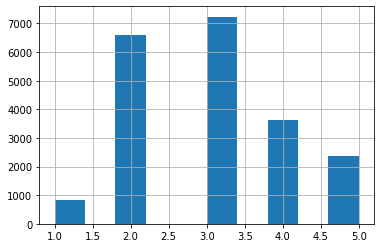

In [47]:
housing["income_cat"].hist()

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

In [50]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [51]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [52]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1,inplace=True)

In [53]:
housing = strat_train_set.copy()

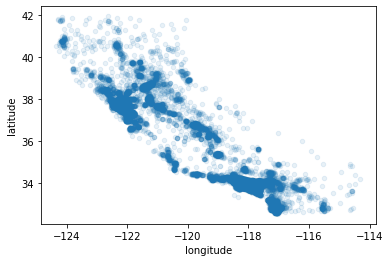

In [55]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

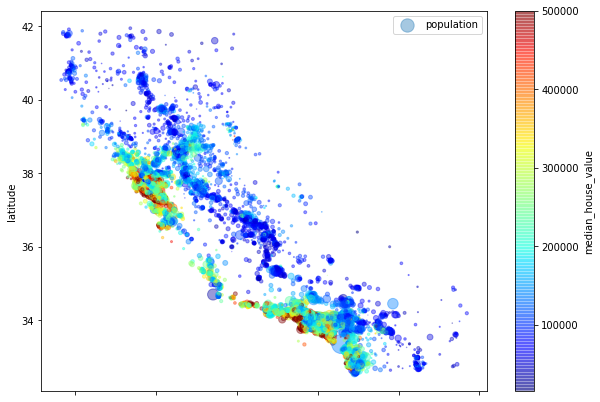

In [56]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

In [57]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [58]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1214e6450>,
      dtype=object)

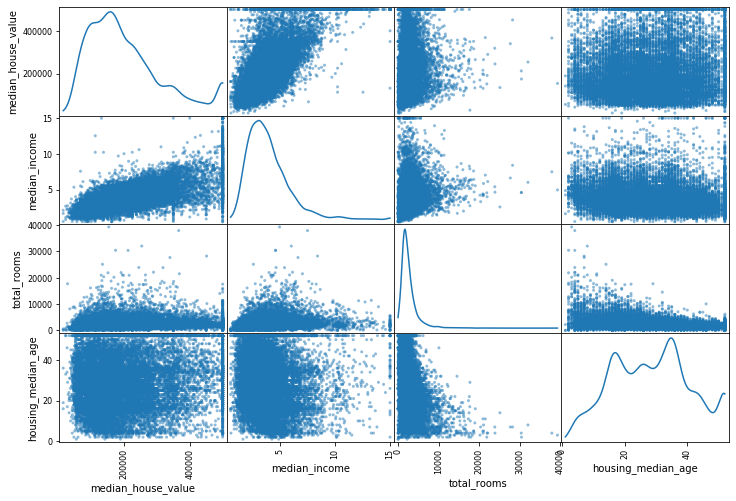

In [60]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal="kde")

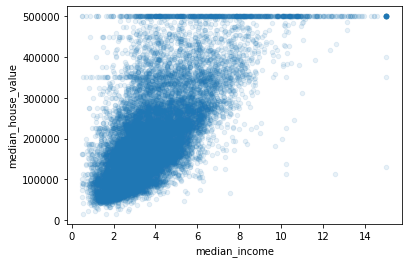

In [61]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [62]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [63]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [64]:
housing = strat_train_set.drop("median_house_value", axis=1) #What is axis=1?
housing_labels = strat_train_set["median_house_value"].copy()

In [65]:
#housing.dropna(subset=["total_bedrooms"]) #removes districs with empty total_bedrooms attributes
#housing.drop("total_bedrooms", axis=1) #removes the whole attribute
#median = housing["total_bedrooms"].median() #computes median from all districts in training set (save for later)
#housing["total_bedrooms"].fillna(median, inplace=True) #replaces empty districts with median

In [66]:
from sklearn.impute import SimpleImputer

In [67]:
imputer = SimpleImputer(strategy="median") #creates instance from class SimpleImputer

In [68]:
housing_num = housing.drop("ocean_proximity", axis=1) #drop non-numerical attributes

In [69]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [70]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [72]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [73]:
X = imputer.transform(housing_num) #creates NumPy array with transformed features

In [74]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns) #Puts it back into a Pandas DataFrame

In [77]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [78]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [79]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [80]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [81]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [82]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin

In [84]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [91]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin): #TransformerMixin gives the fit_transform() for free and BaseEstimator gives get_params() and set_params() for free
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [96]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [97]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [94]:
from sklearn.compose import ColumnTransformer

In [98]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [99]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [100]:
housing_prepared = full_pipeline.fit_transform(housing)

In [101]:
from sklearn.linear_model import LinearRegression

In [102]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:",lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [104]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [105]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [106]:
from sklearn.tree import DecisionTreeRegressor

In [107]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [108]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [110]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [111]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [112]:
display_scores(tree_rmse_scores)

Scores: [70366.32585066 67514.03964598 70177.58760702 68993.35902022
 71567.8467977  75055.83746395 71719.03994344 70027.60576223
 76161.56434281 70127.80542902]
Mean: 71171.1011863025
Standard deviation: 2502.018842290001


In [113]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


In [117]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Training set rmse:", forest_rmse)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set rmse: 21960.017549145214
Scores: [51506.76124482 50449.14648494 51725.85833429 54284.3271087
 52221.66192798 54924.75821427 51363.76949824 50162.8308403
 56248.87557074 53147.67600337]
Mean: 52603.56652276424
Standard deviation: 1898.742684844873


In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [120]:
forest_reg = RandomForestRegressor()

In [121]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [122]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [123]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [124]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [126]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63686.0026180768 {'max_features': 2, 'n_estimators': 3}
55816.93706456032 {'max_features': 2, 'n_estimators': 10}
53133.119915649564 {'max_features': 2, 'n_estimators': 30}
60749.870923673865 {'max_features': 4, 'n_estimators': 3}
53153.33215366251 {'max_features': 4, 'n_estimators': 10}
50322.91179159903 {'max_features': 4, 'n_estimators': 30}
59622.03405768078 {'max_features': 6, 'n_estimators': 3}
52328.864164324994 {'max_features': 6, 'n_estimators': 10}
49998.91576976898 {'max_features': 6, 'n_estimators': 30}
57938.71287254272 {'max_features': 8, 'n_estimators': 3}
52462.84903652386 {'max_features': 8, 'n_estimators': 10}
50059.709491887435 {'max_features': 8, 'n_estimators': 30}
61786.020402688366 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54612.019423693884 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59615.93711772606 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52815.30807963096 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [128]:
feature_importances = grid_search.best_estimator_.feature_importances_ #creates array of feature importances [0,1]

In [129]:
final_model = grid_search.best_estimator_

In [130]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [131]:
X_test_prepared = full_pipeline.transform(X_test)

In [132]:
final_predictions = final_model.predict(X_test_prepared)

In [133]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [134]:
final_rmse

47694.121135153015